In [1]:
import os
from time import time
import pandas as pd
import numpy as np
import pickle
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.utils.extmath import density
from sklearn import svm
from sklearn import naive_bayes
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from sklearn.utils import shuffle

In [2]:
np.random.seed(42)
#seed( ) 用于指定随机数生成时所用算法开始的整数值。
#1.如果使用相同的seed( )值，则每次生成的随即数都相同；
#2.如果不设置这个值，则系统根据时间来自己选择这个值，此时每次生成的随机数因时间差异而不同。
#3.设置的seed()值仅一次有效

In [3]:
comment_file = './data/stock_comments_seg2.csv'
data_path = './data'
pos_corpus = 'positive.txt'
neg_corpus = 'negative.txt'
K_Best_Features = 3000

In [4]:
def load_dataset():
    pos_file = os.path.join(data_path, pos_corpus)
    neg_file = os.path.join(data_path, neg_corpus)

    pos_sents = []
    with open(pos_file, 'r', encoding='utf-8') as f:
        for sent in f:
            pos_sents.append(sent.replace('\n', ''))

    neg_sents = []
    with open(neg_file, 'r', encoding='utf-8') as f:
        for sent in f:
            neg_sents.append(sent.replace('\n', ''))

    balance_len = min(len(pos_sents), len(neg_sents))

    pos_df = pd.DataFrame(pos_sents, columns=['text'])
    pos_df['polarity'] = 1
    pos_df = pos_df[:balance_len]

    neg_df = pd.DataFrame(neg_sents, columns=['text'])
    neg_df['polarity'] = 0
    neg_df = neg_df[:balance_len]

    return pd.concat([pos_df, neg_df]).reset_index(drop=True)
#    return pd.concat([pos_df, neg_df]).sample(frac=1).reset_index(drop=True)

In [5]:
def load_dataset_tokenized():
    pos_file = os.path.join(data_path, pos_corpus)
    neg_file = os.path.join(data_path, neg_corpus)

    pos_sents = []
    with open(pos_file, 'r', encoding='utf-8') as f:
        for line in f:
            tokens = line.split(' ')
            sent = []
            for t in tokens:
                if t.strip():
                    sent.append(t.strip())
            pos_sents.append(sent)

    neg_sents = []
    with open(neg_file, 'r', encoding='utf-8') as f:
        for line in f:
            tokens = line.split(' ')
            sent = []
            for t in tokens:
                if t.strip():
                    sent.append(t.strip())
            neg_sents.append(sent)

    balance_len = min(len(pos_sents), len(neg_sents))

    texts = pos_sents + neg_sents
    labels = [1] * balance_len + [0] * balance_len

    return texts, labels

In [6]:
#TfidfVectorizer可以把原始文本转化为tf-idf的特征矩阵，从而为后续的文本相似度计算，主题模型(如LSI)，文本搜索排序等一系列应用奠定基础
def KFold_validation(clf, X, y):
    acc = []
    pos_precision, pos_recall, pos_f1_score = [], [], []
    neg_precision, neg_recall, neg_f1_score = [], [], []

    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    for train, test in kf.split(X):
        X_train = [X[i] for i in train]
        X_test = [X[i] for i in test]
        y_train = [y[i] for i in train]
        y_test = [y[i] for i in test]

        # vectorizer = TfidfVectorizer(analyzer='word', tokenizer=lambda x : (w for w in x.split(' ') if w.strip()))
        def dummy_fun(doc):
            return doc

        vectorizer = TfidfVectorizer(analyzer='word',
                                     tokenizer=dummy_fun,
                                     preprocessor=dummy_fun,
                                     token_pattern=None)

        vectorizer.fit(X_train)
        X_train = vectorizer.transform(X_train)
        X_test = vectorizer.transform(X_test)

        clf.fit(X_train, y_train)
        preds = clf.predict(X_test)

        acc.append(metrics.accuracy_score(y_test, preds))
        pos_precision.append(metrics.precision_score(y_test, preds, pos_label=1))
        pos_recall.append(metrics.recall_score(y_test, preds, pos_label=1))
        pos_f1_score.append(metrics.f1_score(y_test, preds, pos_label=1))
        neg_precision.append(metrics.precision_score(y_test, preds, pos_label=0))
        neg_recall.append(metrics.recall_score(y_test, preds, pos_label=0))
        neg_f1_score.append(metrics.f1_score(y_test, preds, pos_label=0))


    return (np.mean(acc), np.mean(pos_precision), np.mean(pos_recall), np.mean(pos_f1_score),
            np.mean(neg_precision), np.mean(neg_recall), np.mean(neg_f1_score))

In [7]:
def benchmark_clfs():
    print('Loading dataset...')

    X, y = load_dataset_tokenized()

    classifiers = [
        ('LinearSVC', svm.LinearSVC()),
        ('LogisticReg', LogisticRegression()),
        ('SGD', SGDClassifier()),
        ('MultinomialNB', naive_bayes.MultinomialNB()),
        ('KNN', KNeighborsClassifier()),
        ('DecisionTree', DecisionTreeClassifier()),
        ('RandomForest', RandomForestClassifier()),
        ('AdaBoost', AdaBoostClassifier(base_estimator=LogisticRegression()))
    ]

    cols = ['metrics', 'accuracy',  'pos_precision', 'pos_recall', 'pos_f1_score', 'neg_precision', 'neg_recall', 'neg_f1_score']
    scores = []
    for name, clf in classifiers:
        score = KFold_validation(clf, X, y)
        row = [name]
        row.extend(score)
        scores.append(row)

    df = pd.DataFrame(scores, columns=cols).T
    df.columns = df.iloc[0]
    df.drop(df.index[[0]], inplace=True)
    df = df.apply(pd.to_numeric, errors='ignore')

    return df

In [8]:
def dummy_fun(doc):
        return doc

In [9]:
def eval_model():
    print('Loading dataset...')

    X, y = load_dataset_tokenized()

    clf = svm.LinearSVC()

    vectorizer = TfidfVectorizer(analyzer='word',
                                 tokenizer=dummy_fun,
                                 preprocessor=dummy_fun,
                                 token_pattern=None)

    X = vectorizer.fit_transform(X)

    print('Train model...')
    clf.fit(X, y)

    print('Loading comments...')
    df = pd.read_csv(comment_file)
    df.dropna(inplace=True)
    df.reset_index(drop=True, inplace=True)
    df['created_time'] = pd.to_datetime(df['created_time'], format='%Y-%m-%d %H:%M:%S')
    df['polarity'] = 0
    df['title'].apply(lambda x: [w.strip() for w in x.split()])

    texts = df['title']
    texts = vectorizer.transform(texts)

    preds = clf.predict(texts)
    df['polarity'] = preds

    df.to_csv('stock_comments_analyzed2.csv', index=False)

In [10]:
if __name__ == '__main__':
    scores = benchmark_clfs()
    print(scores)
    scores.to_csv('model_ml_scores2.csv', float_format='%.4f')


    eval_model()

Loading dataset...
metrics        LinearSVC  LogisticReg       SGD  MultinomialNB       KNN  \
accuracy        0.881593     0.880834  0.882353       0.879640  0.820056   
pos_precision   0.880544     0.879024  0.882389       0.882137  0.807142   
pos_recall      0.882481     0.882941  0.881723       0.876015  0.840426   
pos_f1_score    0.881483     0.880898  0.882029       0.879043  0.823396   
neg_precision   0.882443     0.882578  0.882201       0.876666  0.833607   
neg_recall      0.880121     0.878210  0.882241       0.883188  0.799070   
neg_f1_score    0.881251     0.880306  0.882189       0.879890  0.815912   

metrics        DecisionTree  RandomForest  AdaBoost  
accuracy           0.795095      0.847514  0.771659  
pos_precision      0.813365      0.869430  0.797129  
pos_recall         0.765163      0.817591  0.798650  
pos_f1_score       0.788482      0.842650  0.765202  
neg_precision      0.778262      0.827652  0.825027  
neg_recall         0.824773      0.877225  0.759

In [11]:
import pandas as pd
import numpy as np

In [12]:
df = pd.read_csv('stock_comments_analyzed2.csv',encoding='gb18030',parse_dates=['created_time'])
grouped = df['polarity'].groupby(df.created_time.dt.date)

In [13]:
df.tail()

,created_time,title,polarity
473606,2017-07-14 10:01:00,寒 珠峰 山之巅 高处不胜,0
473607,2017-07-14 09:58:00,涨停 科技 几分钟 永悦,1
473608,2017-07-14 09:55:00,动力 暴涨 全柴 潜力 特大,1
473609,2017-07-14 09:54:00,谷 有多深 峰 涨 高 天上 不信,1
473610,2017-07-14 09:47:00,大笑 目标 预测,1


In [14]:
def BI_Simple_func(row):
    pos = row[row == 1].count()
    neg = row[row == 0].count()

    return (pos-neg)/(pos+neg)

In [15]:
BI_Simple_index = grouped.apply(BI_Simple_func)

In [16]:
BI_Simple_index.head()

created_time
2017-07-14   -0.118644
2017-07-15   -0.292308
2017-07-16   -0.018182
2017-07-17   -0.256098
2017-07-18   -0.007519
Name: polarity, dtype: float64

In [17]:
def BI_func(row):
    pos = row[row == 1].count()
    neg = row[row == 0].count()

    bi = np.log(1.0 * (1+pos) / (1+neg))

    return bi

In [18]:
BI_index = grouped.apply(BI_func)

In [19]:
sentiment_idx = pd.concat([BI_index.rename('BI'), BI_Simple_index.rename('BI_Simple')], axis=1)

In [20]:
sentiment_idx.head()

,BI,BI_Simple
created_time,,
2017-07-14,-0.234401,-0.118644
2017-07-15,-0.583146,-0.292308
2017-07-16,-0.035091,-0.018182
2017-07-17,-0.517257,-0.256098
2017-07-18,-0.014815,-0.007519


In [21]:
quotes = pd.read_csv('./data/stock_data_600519.csv', parse_dates=['date'])
quotes.set_index('date', inplace=True)

In [22]:
quotes.head()

,open,high,low,close,volume
date,,,,,
2017-07-14,456.25,458.76,453.05,456.41,1772657
2017-07-17,457.04,458.04,446.28,450.07,3526368
2017-07-18,451.99,453.99,448.00,452.55,3068449
2017-07-19,454.00,463.62,452.80,456.86,5625994
2017-07-20,455.86,466.89,455.86,466.47,4663487


In [23]:
sentiment_idx.index = pd.to_datetime(sentiment_idx.index)
merged = pd.merge(sentiment_idx, quotes, how='left', left_index=True, right_index=True)

In [24]:
merged.head()

,BI,BI_Simple,open,high,low,close,volume
created_time,,,,,,,
2017-07-14,-0.234401,-0.118644,456.25,458.76,453.05,456.41,1772657.0
2017-07-15,-0.583146,-0.292308,NaN,NaN,NaN,NaN,NaN
2017-07-16,-0.035091,-0.018182,NaN,NaN,NaN,NaN,NaN
2017-07-17,-0.517257,-0.256098,457.04,458.04,446.28,450.07,3526368.0
2017-07-18,-0.014815,-0.007519,451.99,453.99,448.00,452.55,3068449.0


In [25]:
merged.fillna(method='ffill', inplace=True)
merged['BI_MA'] = merged['BI'].rolling(window=10, center=False).mean()
merged['BI_Simple_MA'] = merged['BI_Simple'].rolling(window=10, center=False).mean()

In [26]:
merged.head()

,BI,BI_Simple,open,high,low,close,volume,BI_MA,BI_Simple_MA
created_time,,,,,,,,,
2017-07-14,-0.234401,-0.118644,456.25,458.76,453.05,456.41,1772657.0,NaN,NaN
2017-07-15,-0.583146,-0.292308,456.25,458.76,453.05,456.41,1772657.0,NaN,NaN
2017-07-16,-0.035091,-0.018182,456.25,458.76,453.05,456.41,1772657.0,NaN,NaN
2017-07-17,-0.517257,-0.256098,457.04,458.04,446.28,450.07,3526368.0,NaN,NaN
2017-07-18,-0.014815,-0.007519,451.99,453.99,448.00,452.55,3068449.0,NaN,NaN


In [27]:
merged.to_csv('merged_sentiment_idx2.csv')

In [28]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

In [29]:
mpl.rcParams['font.sans-serif']=['SimHei']#设置字体样式以正常显示中文
mpl.rcParams['axes.unicode_minus'] = False#使用Unicode格式的负号

In [30]:
df = pd.read_csv('merged_sentiment_idx2.csv')
df.head()

,created_time,BI,BI_Simple,open,high,low,close,volume,BI_MA,BI_Simple_MA
0,2017-07-14,-0.234401,-0.118644,456.25,458.76,453.05,456.41,1772657.0,NaN,NaN
1,2017-07-15,-0.583146,-0.292308,456.25,458.76,453.05,456.41,1772657.0,NaN,NaN
2,2017-07-16,-0.035091,-0.018182,456.25,458.76,453.05,456.41,1772657.0,NaN,NaN
3,2017-07-17,-0.517257,-0.256098,457.04,458.04,446.28,450.07,3526368.0,NaN,NaN
4,2017-07-18,-0.014815,-0.007519,451.99,453.99,448.00,452.55,3068449.0,NaN,NaN


In [31]:
df = pd.read_csv('merged_sentiment_idx2.csv')
df['created_time']=pd.to_datetime(df['created_time'])
df.set_index(df.created_time, inplace=True)
#df=df.dropna()
df.head()

,created_time,BI,BI_Simple,open,high,low,close,volume,BI_MA,BI_Simple_MA
created_time,,,,,,,,,,
2017-07-14,2017-07-14,-0.234401,-0.118644,456.25,458.76,453.05,456.41,1772657.0,NaN,NaN
2017-07-15,2017-07-15,-0.583146,-0.292308,456.25,458.76,453.05,456.41,1772657.0,NaN,NaN
2017-07-16,2017-07-16,-0.035091,-0.018182,456.25,458.76,453.05,456.41,1772657.0,NaN,NaN
2017-07-17,2017-07-17,-0.517257,-0.256098,457.04,458.04,446.28,450.07,3526368.0,NaN,NaN
2017-07-18,2017-07-18,-0.014815,-0.007519,451.99,453.99,448.00,452.55,3068449.0,NaN,NaN


In [32]:
fig, ax1 = plt.subplots()

ax2 = ax1.twinx()#产生一个ax1的镜面坐标作为次坐标轴
ax1.plot(df.index, df['BI_MA'], color='g', linestyle=':')
ax2.plot(df.index, df['close'], color='b')
ax1.set_xlabel('日期')
ax1.set_ylabel('BI指标')
ax2.set_ylabel('茅台股价')

#plt.show()
plt.savefig('茅台.png')

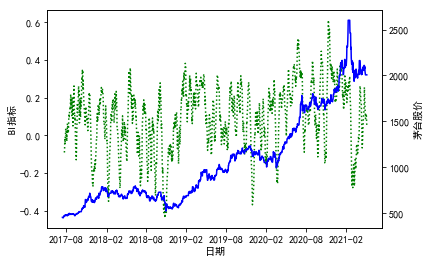

In [33]:
plt.show()